In [1]:
import pandas as pd
import numpy as np
import torch as T
from torch import nn
import torch.nn.functional as F

import chemprop
import rdkit

import pickle as pkl
import gzip

from tqdm.notebook import tqdm
import argparse

import random

In [2]:
import covid
from covid.datasets import *
from covid.modules import *
from covid.data import *
from covid.model import *
from covid.schedulers import LinearWarmupScheduler
from covid.reporting import get_performance_plots

from covid.modules.chemistry import MPNEncoder

In [3]:
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

In [4]:
import covid.training

In [5]:
import logging

In [34]:
x = np.linspace(0,20,1000)

50.0

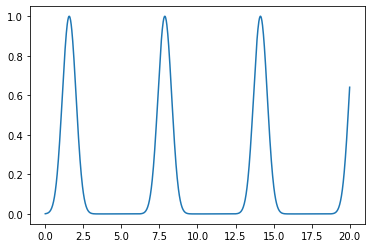

In [49]:
y = (0.5*(np.sin(x)+1))**10
plt.plot(x,y)

In [6]:
logging.basicConfig(level=logging.DEBUG)

In [7]:
config = covid.training.CovidTrainingConfiguration()

In [14]:
dl, _ = covid.training._create_dataloaders(config)
idl = iter(dl)

DEBUG:root:Initializing Datasets


In [20]:
data = next(idl)
_, chem_batch, chem_f_batch, prot_batch, _ = data
model = covid.training._create_model(config)
res = model(chem_batch, chem_f_batch, prot_batch)
res

DEBUG:root:Creating model
DEBUG:root:0... OK
DEBUG:root:1... OK
DEBUG:root:2... OK
DEBUG:root:3... OK
DEBUG:root:4... OK
DEBUG:root:5... OK
DEBUG:root:6... OK
DEBUG:root:7... OK
DEBUG:root:8... OK


tensor([[0.5131, 0.4869, 0.4894, 0.5118, 0.4741],
        [0.5138, 0.5024, 0.5102, 0.5096, 0.4811],
        [0.4999, 0.4848, 0.5034, 0.5045, 0.4897],
        [0.4885, 0.4915, 0.4975, 0.5093, 0.4793],
        [0.4966, 0.4932, 0.4925, 0.4981, 0.4900],
        [0.5102, 0.4789, 0.4980, 0.5171, 0.4888],
        [0.5082, 0.4732, 0.5263, 0.5101, 0.4645],
        [0.4892, 0.5125, 0.5071, 0.4997, 0.4602],
        [0.5002, 0.4908, 0.5212, 0.5246, 0.4668],
        [0.5076, 0.4917, 0.4889, 0.5368, 0.4770],
        [0.5095, 0.4978, 0.5066, 0.5207, 0.4856],
        [0.4913, 0.4799, 0.4961, 0.5094, 0.4795],
        [0.5040, 0.5012, 0.5042, 0.5029, 0.4807],
        [0.5368, 0.5003, 0.4950, 0.5128, 0.4909],
        [0.4974, 0.4915, 0.5018, 0.4984, 0.4915],
        [0.4986, 0.4994, 0.5201, 0.5281, 0.4732],
        [0.5084, 0.4830, 0.5026, 0.5135, 0.4876],
        [0.5178, 0.5011, 0.5119, 0.5297, 0.4754],
        [0.5059, 0.5051, 0.5005, 0.4999, 0.4704],
        [0.5028, 0.4737, 0.4921, 0.5000, 0.4806],


In [17]:
from hyperopt import Trials

In [18]:
from hyperopt.mongoexp import MongoTrials
import hyperopt

In [10]:
from IPython.display import display, clear_output
from time import sleep



In [517]:
def plot_param(pname):

    xs = []
    ys = []

    for t in mtrials.trials:
        if t['result'].get('loss') is None:
            continue
        params = hyperopt.space_eval(search_space, {k:v[0] for k,v in t['misc']['vals'].items()})
        xs.append(params[pname])
        ys.append(t['result']['loss'])

    fig, ax = plt.subplots()
    ax.scatter(xs, ys)
    ax.set_yscale('log')
    if pname == 'optim_initial_lr':
        ax.set_xscale('log')
        ax.set_xlim(1e-5.5, 1e-1.5)
    ax.set_title(pname)
    
    display(fig)
    plt.close(fig)

SyntaxError: invalid syntax (<ipython-input-517-d7c0e6c130d7>, line 18)

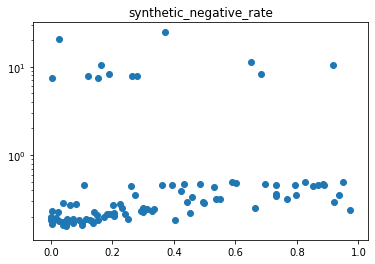

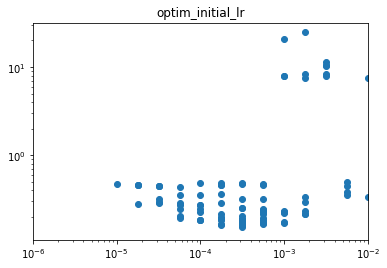

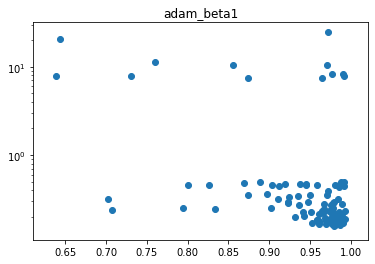

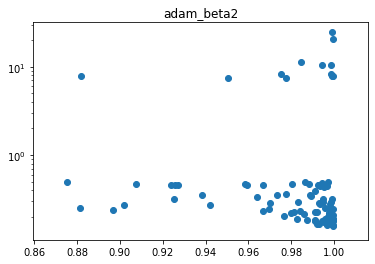

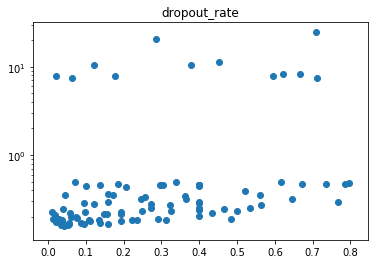

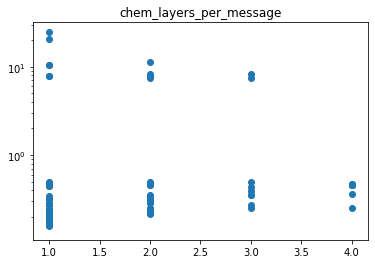

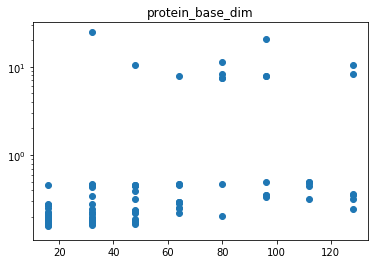

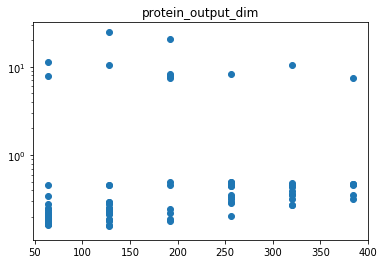

In [518]:
for param in ['synthetic_negative_rate', 'optim_initial_lr', 'adam_beta1', 'adam_beta2', 'dropout_rate', 'chem_layers_per_message', 'protein_base_dim', 'protein_output_dim']:
    plot_param(param)

In [533]:
from collections import Counter, defaultdict

In [553]:
from IPython.display import HTML

In [5]:
import pymongo

In [15]:
from pymongo import MongoClient
client = MongoClient('localhost', 1234)

In [7]:
jobs = client.covid['jobs']

In [8]:
from covid.training import set_random_seeds
from covid.datasets import create_data_split, StitchDataset

In [13]:
import logging
import sys
logging.basicConfig(level=logging.DEBUG)

In [14]:
DROPOUT_RATE = 0.4
BATCH_SIZE = 16

VALIDATION_FREQUENCY = 0.2

In [15]:
DEVICE = 'cuda'

In [16]:
from covid.training import _create_model, CovidTrainingConfiguration, _create_dataloaders

In [17]:
config = CovidTrainingConfiguration()

In [18]:
DEVICE = 'cpu'
model = _create_model(config)

DEBUG:covid.training:Creating model


In [19]:
from covid.training import _create_optimizer_and_schedulers

In [20]:
optim, _, _ = _create_optimizer_and_schedulers(model, config)

DEBUG:covid.training:Initializing optimizers/schedulers


In [67]:
dl, vdl = _create_dataloaders(config)

DEBUG:covid.training:Initializing Datasets


In [93]:
TOTAL_TIME = 0
TOTAL_CALLS = 0

import time

class timed_iter():
    def __init__(self, inner_iterable):
        self._iter = iter(inner_iterable)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        global TOTAL_TIME, TOTAL_CALLS
        start_time = time.process_time()
        res = next(self._iter)
        end_time = time.process_time()
        TOTAL_TIME += (end_time-start_time)
        TOTAL_CALLS += 1
        return res

In [101]:
bins = T.zeros(10,5)

weight_sums = T.zeros(5)

for batch in timed_iter(dl):
    _, _, _, _, target = batch
    
    weights = (target * 0.0015).clamp(1e-3, 1.0)
    weights[target == 0] = 0  # 0.5
    weight_sums += weights.sum(0)
    
    upd = T.zeros(10,5)
    for i in range(9):
        upd[i,:] = (target <= i*100).sum(0)
    
    upd[9,:] = target.shape[0]
    upd[1:] = upd[1:] - upd[:-1]
    bins += upd

In [107]:
T.tensor([[1,2,3,4,5.0]]).shape

torch.Size([1, 5])

In [106]:
weight_sums.mean()/weight_sums

tensor([2.0181, 0.4526, 3.8953, 0.5940, 2.8166])

<BarContainer object of 5 artists>

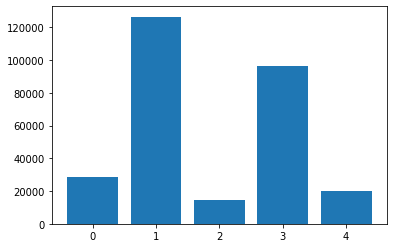

In [102]:
plt.bar(np.arange(5), weight_sums.numpy())

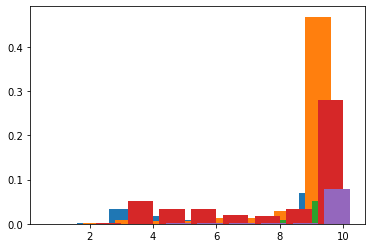

In [103]:
for i in range(5):
    plt.bar(np.arange(1,10) + i*0.2, (bins/bins.sum(0,keepdim=True)).numpy()[1:,i])

In [97]:
TOTAL_TIME

6.125

In [51]:
epoch = 0
last_validation = epoch
losses = []
validation_stats = []

if os.path.exists("./training_state/train_fold00__state.pkl.gz"):
    with gzip.open("./training_state/train_fold00__state.pkl.gz", "rb") as f:
        state = T.load(f, map_location=DEVICE)
        
#     epoch = state.get('epoch', epoch)
#     losses = state.get('losses', losses)
#     validation_stats = state.get('validation_stats', validation_stats)
#     last_validation = state.get('last_validation', last_validation)
#     model.load_state_dict(state['model'])
#     optim.load_state_dict(state['optim'])
    #warmup.load_state_dict(state['warmup'])
    
# if epoch == 0:
#     vloss, vacc, v_conf = get_validation_loss()
#     validation_stats.append([0, vloss, vacc, v_conf])

In [55]:
state['scheduler']['_last_lr']=[1e-5]

In [56]:
state['scheduler']['best'] = 1.0

In [60]:
for pg in state['optim']['param_groups']:
    pg['lr'] = 1e-5

In [66]:
with gzip.open("./training_state/train_fold00__state.pkl.gz", "wb") as f:
    T.save(state, f)

In [25]:
(1.0*(model.final_layers[0].is_log == model.context_model[0].is_log)).mean()

tensor(0.8586)

In [19]:
if not os.path.exists("./checkpoints/"):
    os.mkdir("./checkpoints")

In [20]:
chart_area = widgets.Output()
display(chart_area)

for epoch in tqdm(range(epoch, 100)):
    idx = 0
    
    model.train()
    pct_epoch = 0
    
    for batch in tqdm(dataloader, leave=False):

        model.zero_grad()
        _, _, loss, _ = run_model(model, batch, DEVICE)

        loss.backward()

        optim.step()
        warmup.step()
            
        idx += BATCH_SIZE
        pct_epoch = min(1.0, idx/len(data))
        
        losses.append((epoch + pct_epoch, loss.item()))
        
        if pct_epoch == 1.0 or epoch + pct_epoch - last_validation > VALIDATION_FREQUENCY:
            vloss, vacc, v_conf = get_validation_loss()
            validation_stats.append([epoch+pct_epoch, vloss, vacc, v_conf])
            
            chart_area.clear_output()
            fig = get_performance_plots(losses, validation_stats)
            with chart_area:
                display(fig)
            plt.close(fig)
            
            last_validation = epoch + pct_epoch
            
    state = {
        'epoch': epoch,
        'losses': losses,
        'validation_stats': validation_stats,
        'last_validation': last_validation,
        'model': model.state_dict(),
        'optim': optim.state_dict(),
        'warmup': warmup.state_dict(),
    }
    T.save(state, f'./checkpoints/model_00_{epoch:03}.pkl')
    T.save(state, "./training_state_00.pkl")

Output()

KeyboardInterrupt: 

In [ ]:
plot_losses(losses, validation_stats, max(10, len(losses)//2000))